## Capstone project - Sentiment analysis based stock market trading decision making

### Import all the relevant packages

In [3]:
#Basic modules
import time
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import progressbar

#Yahoo finance modules
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

#NLP Modules
import nltk
import twython
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rajeevnair/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rajeevnair/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rajeevnair/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## For MVP purpose we limit our analyses to the FAANG stocks.
### We use tickr news section from finviz.com to get the relevant commentaries about the stock and market.

In [4]:
tickr = ['fb','aapl','amzn','nflx','googl']

p = progressbar.ProgressBar()

p.start()

fb = requests.get("https://finviz.com/quote.ashx?t=FB")
aapl = requests.get("https://finviz.com/quote.ashx?t=AAPL")
amzn = requests.get("https://finviz.com/quote.ashx?t=AMZN")
nflx = requests.get("https://finviz.com/quote.ashx?t=NFLX")
googl = requests.get("https://finviz.com/quote.ashx?t=GOOGL")

fb_soup = BeautifulSoup(fb.content, 'html.parser')
aapl_soup = BeautifulSoup(aapl.content, 'html.parser')
amzn_soup = BeautifulSoup(amzn.content, 'html.parser')
nflx_soup = BeautifulSoup(nflx.content, 'html.parser')
googl_soup = BeautifulSoup(googl.content, 'html.parser')

p.finish()


100% |########################################################################|


## Scrape the commentaries seciton from finviz.com

In [5]:
#FB 

table = fb_soup.find_all(lambda tag: tag.name=='table')
rows = table[31].findAll(lambda tag: tag.name=='tr')
FB=[]
for i in range(len(rows)):
    td=rows[i].find_all('td')
    FB=FB+[x.text for x in td]

#AAPL

table = aapl_soup.find_all(lambda tag: tag.name=='table')
rows = table[31].findAll(lambda tag: tag.name=='tr')
AAPL=[]
for i in range(len(rows)):
    td=rows[i].find_all('td')
    AAPL=AAPL+[x.text for x in td]

#AMZN

table = amzn_soup.find_all(lambda tag: tag.name=='table')
rows = table[31].findAll(lambda tag: tag.name=='tr')
AMZN=[]
for i in range(len(rows)):
    td=rows[i].find_all('td')
    AMZN=AMZN+[x.text for x in td]
    
#NFLX

table = nflx_soup.find_all(lambda tag: tag.name=='table')
rows = table[31].findAll(lambda tag: tag.name=='tr')
NFLX=[]
for i in range(len(rows)):
    td=rows[i].find_all('td')
    NFLX=NFLX+[x.text for x in td]
    
#GOOGL

table = googl_soup.find_all(lambda tag: tag.name=='table')
rows = table[31].findAll(lambda tag: tag.name=='tr')
GOOGL=[]
for i in range(len(rows)):
    td=rows[i].find_all('td')
    GOOGL=GOOGL+[x.text for x in td]

### Capture the relevant commentaries of various tickrs into a pandas dataframe

In [6]:
df = pd.DataFrame(columns=['tickr','comments'])

df.loc[0] = ['FB',FB[0]]
df.loc[1] = ['AAPL', AAPL[0]]
df.loc[2] = ['AMZN', AMZN[0]]
df.loc[3] = ['NFLX', NFLX[0]]
df.loc[4] = ['GOOGL', GOOGL[0]]

df.shape

(5, 2)

## Sentiment Analysis

### Positivity index is defined as the ratio of positive comments & negative comments multiplied by 100.
#### An index of 100 refers to neutral sentiments. An index below 100 represents negative sentiments and an index above 100 refers to positive sentiments

In [7]:
df['positivity_index']= ''
df['buy/sell'] =''

for i in range(0,len(df)):
    text = str(df.comments[i])
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
    negative = sia.polarity_scores(text)['neg']
    positive = sia.polarity_scores(text)['pos']
    
    Positivity_Index = positive*100/negative
    
    print("Positivity Index of " + tickr[i] + " is : " ,Positivity_Index)
    if Positivity_Index > 100:
        Signal = 'BUY'
    else:
        Signal = 'SELL'
    
    df['positivity_index'].loc[i] = Positivity_Index
    df['buy/sell'].loc[i] = Signal
    


Positivity Index of fb is :  82.90598290598291
Positivity Index of aapl is :  133.33333333333331
Positivity Index of amzn is :  174.64788732394368
Positivity Index of nflx is :  139.70588235294116
Positivity Index of googl is :  138.66666666666669


## Save sentiment data for the day

In [8]:
df[['tickr','positivity_index', 'buy/sell']].to_csv('12Apr.csv',encoding='utf-8')

## Plot sentiments

In [9]:
from matplotlib import pyplot as plt
import datetime
date = datetime.datetime(2020,4,8)
result = pd.DataFrame(columns = ['tickr','positivity_index','buy/sell','date'])

In [10]:
for i in os.listdir('./data'):
    data = pd.read_csv('./data/'+i)
    data = data[['tickr','positivity_index','buy/sell']]
    stage = data[['tickr','positivity_index','buy/sell']]
    stage['date'] = str(date)
    date += datetime.timedelta(days=1)
    result = result.append(stage)

In [11]:
result = result.reset_index()
positivity_data = result[['date','tickr','buy/sell','positivity_index']]


fb_positivity = positivity_data[positivity_data.tickr == 'FB']
aapl_positivity = positivity_data[positivity_data.tickr == 'AAPL']
amzn_positivity = positivity_data[positivity_data.tickr == 'AMZN']
nflx_positivity = positivity_data[positivity_data.tickr == 'NFLX']
googl_positivity = positivity_data[positivity_data.tickr == 'GOOGL']



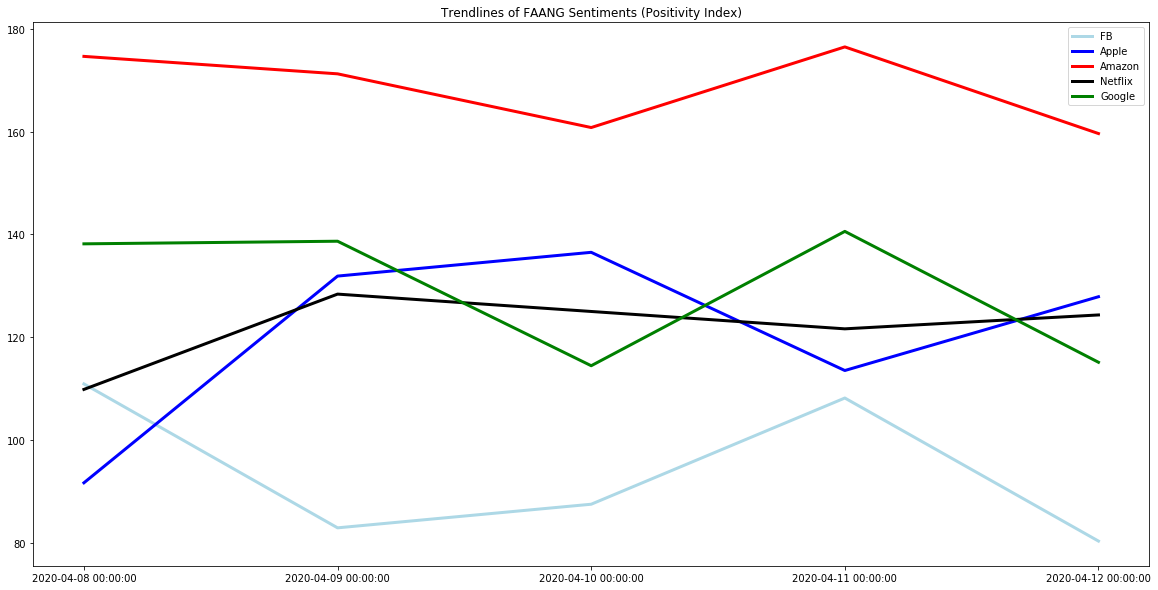

In [12]:
plt.figure(figsize=(20,10))
plt.plot(fb_positivity.date,fb_positivity.positivity_index,color='lightblue',linewidth=3,label='FB')
plt.plot(aapl_positivity.date,aapl_positivity.positivity_index,color='blue',linewidth=3,label='Apple')
plt.plot(amzn_positivity.date,amzn_positivity.positivity_index,color='red',linewidth=3,label='Amazon')
plt.plot(nflx_positivity.date,nflx_positivity.positivity_index,color='black',linewidth=3,label='Netflix')
plt.plot(googl_positivity.date,googl_positivity.positivity_index,color='green', linewidth=3,label='Google')
plt.legend()
plt.title('Trendlines of FAANG Sentiments (Positivity Index)')
plt.show()



## Plot Closing price changes (pct_change())

In [13]:
tickr_price = pd.DataFrame(columns=['tickr','data','price'])

fb_price = pdr.get_data_yahoo("FB", start="2020-04-08", end="2020-08-12")
aapl_price = pdr.get_data_yahoo("AAPL", start="2020-04-08", end="2020-08-12")
amzn_price = pdr.get_data_yahoo("AMZN", start="2020-04-08", end="2020-08-12")
nflx_price = pdr.get_data_yahoo("NFLX", start="2020-04-08", end="2020-08-12")
googl_price = pdr.get_data_yahoo("GOOGL", start="2020-04-08", end="2020-08-12")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
fb_price['pct_change'] = fb_price.Close.pct_change()
fb_price = fb_price.dropna()
aapl_price['pct_change'] = aapl_price.Close.pct_change()
aapl_price = aapl_price.dropna()
amzn_price['pct_change'] = amzn_price.Close.pct_change()
amzn_price = amzn_price.dropna()
nflx_price['pct_change'] = nflx_price.Close.pct_change()
nflx_price = nflx_price.dropna()
googl_price['pct_change'] = googl_price.Close.pct_change()
googl_price = googl_price.dropna()

In [15]:
fb_price['Date'] = ['2020-04-08','2020-04-09']
aapl_price['Date'] = ['2020-04-08','2020-04-09']
amzn_price['Date'] = ['2020-04-08','2020-04-09']
nflx_price['Date'] = ['2020-04-08','2020-04-09']
googl_price['Date'] = ['2020-04-08','2020-04-09']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Plot trendlines

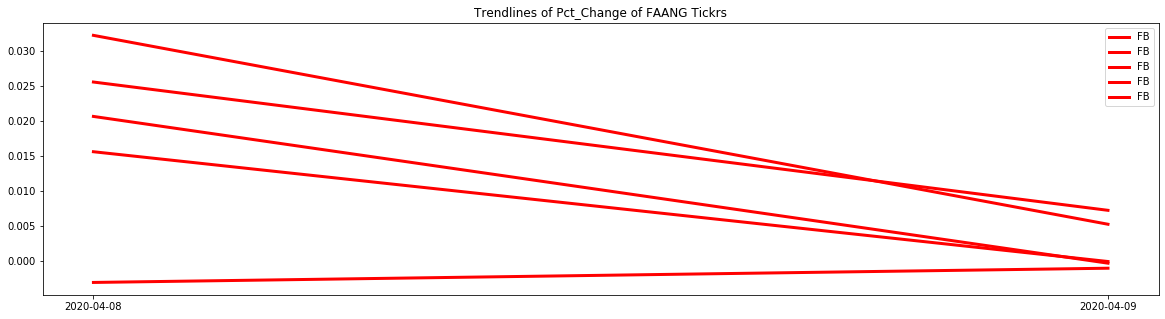

In [16]:
plt.figure(figsize=(20,5))
plt.plot(fb_price['Date'],fb_price['pct_change'],color='red',linewidth=3,label='FB')
plt.plot(aapl_price['Date'],aapl_price['pct_change'],color='red',linewidth=3,label='FB')
plt.plot(amzn_price['Date'],amzn_price['pct_change'],color='red',linewidth=3,label='FB')
plt.plot(nflx_price['Date'],nflx_price['pct_change'],color='red',linewidth=3,label='FB')
plt.plot(googl_price['Date'],googl_price['pct_change'],color='red',linewidth=3,label='FB')
plt.legend()
plt.title('Trendlines of Pct_Change of FAANG Tickrs')
plt.show()

## Find Correlation

In [17]:
Corr_Matrix = pd.DataFrame(columns=['tickr','correlation coefficient'])

## Facebook 
col1 = pd.DataFrame(fb_price['pct_change'])
col2 = pd.DataFrame(fb_positivity['positivity_index'].head(2))
col1 = col1.reset_index()
col2 = col2.reset_index()
cc = col2['positivity_index'].corr(col1['pct_change'])
Corr_Matrix.loc[0] = ['FB',cc]

## AAPL 
col1 = pd.DataFrame(aapl_price['pct_change'])
col2 = pd.DataFrame(aapl_positivity['positivity_index'].head(2))
col1 = col1.reset_index()
col2 = col2.reset_index()
cc = col2['positivity_index'].corr(col1['pct_change'])
Corr_Matrix.loc[1] = ['AAPL',cc]

## AMZN 
col1 = pd.DataFrame(amzn_price['pct_change'])
col2 = pd.DataFrame(amzn_positivity['positivity_index'].head(2))
col1 = col1.reset_index()
col2 = col2.reset_index()
cc = col2['positivity_index'].corr(col1['pct_change'])
Corr_Matrix.loc[2] = ['AMZN',cc]

## NETFLIX 
col1 = pd.DataFrame(nflx_price['pct_change'])
col2 = pd.DataFrame(nflx_positivity['positivity_index'].head(2))
col1 = col1.reset_index()
col2 = col2.reset_index()
cc = col2['positivity_index'].corr(col1['pct_change'])
Corr_Matrix.loc[3] = ['NFLX',cc]

## GOOGLE 
col1 = pd.DataFrame(googl_price['pct_change'])
col2 = pd.DataFrame(googl_positivity['positivity_index'].head(2))
col1 = col1.reset_index()
col2 = col2.reset_index()
cc = col2['positivity_index'].corr(col1['pct_change'])
Corr_Matrix.loc[4] = ['GOOGL',cc]

In [18]:
Corr_Matrix

,tickr,correlation coefficient
0,FB,1.0
1,AAPL,-1.0
2,AMZN,1.0
3,NFLX,1.0
4,GOOGL,-1.0
